<a href="https://colab.research.google.com/github/6arlos6/Ideal_Gas/blob/main/Idela_Gas_N_particles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cargar librerias:



In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation

import scipy.stats as stats
import scipy.io

# Definir Clase < Particle > :

In [16]:
class Particle:
  def __init__(self, mass, radius, position, velocity):
    self.mass = mass
    self.radius = radius
    self.position = position
    self.velocity = velocity

# Constantes y tiempo:

In [24]:
# Constantes:

N = 100

inferior_box = -20
superior_box = 20

Ra = -1.
Rb = 15.

r0 = 0.5
R = 2
mu, sigma = 0., 15.
m = 0.01

FPS = 60

# Tiempo:

Dt = 0.001
time = np.arange(0,3,Dt)

# Condiciones Iniciales ( $ \mathbf{r}_{i}(0)$ , $\mathbf{v}_{i}(0)$):

## Funcion para def. $ \mathbf{r}_{i}(0)$ sin solapes:

In [4]:
def initial_pos(N, r0, R, a, b):
# N := Numero de particulas.
# r0 := radio de las particulas.
# R := Dimension del sistema.
# s:= Rango maximo de volumen.
  r = np.zeros((N,R))
  for i in range(1,N):
    band0 = 1
    while band0 >= 1:
      band0 = 0
      rt = (b-a)*np.random.rand(1,R) + a
      for j in range(0, i):
        rij = np.linalg.norm(rt - r[j])
        if rij <= 2*r0:
          band0 +=1
    r[i] = rt
  return r

In [19]:
# Chat gpt

def initial_pos(N, r0, R, a, b):
    r = np.zeros((N, R))
    for i in range(1, N):
        band0 = 1
        while band0 >= 1:
            band0 = 0
            rt = np.random.uniform(a, b, size=(1, R))
            rij = np.linalg.norm(rt - r[:i], axis=1)
            if np.any(rij <= 2 * r0):
                band0 += 1
        r[i] = rt
    return r

## Definir ensemble + C.I.

In [20]:
Ensemble_Particles = []

R0 = initial_pos(N, r0, R, Ra, Rb)

for i in range(0,N):
  zpi = np.zeros([len(time),R])
  zpi[0] = R0[i]
  zvi = np.zeros([len(time),R])
  zvi[0] = np.random.normal(mu, sigma, [R])
  Ensemble_Particles.append(Particle(m, r0, zpi, zvi))


# Eventos - Interacciones:

## Función de choque con paredes:

In [6]:
def isWall(p,n,m,r,i):

	tf1 = 0
	tf2 = 0

	if p.position[i,1] < (n + r) or p.position[i,1] >= m - r:
		p.velocity[i,1] = -p.velocity[i,1]
		p.velocity[i+1] = p.velocity[i]
		tf1 = 1

	if p.position[i,0] < (n + r) or p.position[i,0] >= m - r:
		p.velocity[i,0] = -p.velocity[i,0]
		p.velocity[i+1] = p.velocity[i]
		tf2 = 1

	if tf1 == 0 and tf2 == 0:
		p.velocity[i+1] = p.velocity[i]

	return p

In [21]:
def isWall(p, n, m, r, i):
    tf1 = 0
    tf2 = 0
    pos_i = p.position[i]
    vel_i = p.velocity[i]

    if pos_i[1] < (n + r) or pos_i[1] >= m - r:
        vel_i[1] = -vel_i[1]
        tf1 = 1

    if pos_i[0] < (n + r) or pos_i[0] >= m - r:
        vel_i[0] = -vel_i[0]
        tf2 = 1

    if tf1 == 0 and tf2 == 0:
        p.velocity[i+1] = vel_i

    p.velocity[i+1] = vel_i
    return p


## Función de colición entre particulas:

In [7]:
def isCollision(p1,p2,i):

	# i = 1 ---- j = 2

	a = (p1.position[i,0] - p2.position[i,0])**2
	b = (p1.position[i,1] - p2.position[i,1])**2
	d = np.sqrt(a + b)

	if d < (p1.radius + p2.radius)**1.1:
		rij = (p1.position[i] - p2.position[i])/(d)
		A = -2*((p1.mass*p2.mass)/(p1.mass + p2.mass))
		B = p1.velocity[i] - p2.velocity[i]
		C = np.dot(B, rij)
		q = (A*C)*rij
		p1.velocity[i] = p1.velocity[i] + q/p1.mass
		p1.velocity[i+1] = p1.velocity[i]
		p2.velocity[i] = p2.velocity[i] - q/p2.mass
		p2.velocity[i+1] = p2.velocity[i]

	return p1, p2

In [ ]:
def isCollision(p1, p2, i):
    a = (p1.position[i, 0] - p2.position[i, 0])**2
    b = (p1.position[i, 1] - p2.position[i, 1])**2
    d_squared = a + b

    if d_squared < (p1.radius + p2.radius)**2.2:  # Evitar la raíz cuadrada
        rij = (p1.position[i] - p2.position[i]) / np.sqrt(d_squared)
        A = -2 * ((p1.mass * p2.mass) / (p1.mass + p2.mass))
        B = p1.velocity[i] - p2.velocity[i]
        C = np.dot(B, rij)
        q = (A * C) * rij
        p1.velocity[i] += q / p1.mass
        p1.velocity[i+1] = p1.velocity[i]
        p2.velocity[i] -= q / p2.mass
        p2.velocity[i+1] = p2.velocity[i]

    return p1, p2


In [22]:
def isCollision(p1, p2, i):
    a = (p1.position[i, 0] - p2.position[i, 0])**2
    b = (p1.position[i, 1] - p2.position[i, 1])**2
    d_squared = a + b

    if d_squared < (p1.radius + p2.radius)**2.2:  # Evitar la raíz cuadrada
        rij = (p1.position[i] - p2.position[i]) / np.sqrt(d_squared)
        A = -2 * ((p1.mass * p2.mass) / (p1.mass + p2.mass))
        B = p1.velocity[i] - p2.velocity[i]
        C = np.dot(B, rij)
        q = (A * C) * rij
        p1.velocity[i] += q / p1.mass
        p1.velocity[i+1] = p1.velocity[i]
        p2.velocity[i] -= q / p2.mass
        p2.velocity[i+1] = p2.velocity[i]

    return p1, p2


# Evolución temporal ( $ \mathbf{r}_{i}(t)$ , $\mathbf{v}_{i}(t)$):

In [ ]:
for i in range(0,len(time)-1):
  print('time = {} [s] \n'.format(time[i]))

  for j in range(0,N):
    pj = Ensemble_Particles[j]
    pj = isWall(pj, inferior_box, superior_box, pj.radius, i)
    Ensemble_Particles[j] = pj

  for ki in range(0,N):
    for kj in range(ki+1,N):
      pki = Ensemble_Particles[ki]
      pkj = Ensemble_Particles[kj]
      pki, pkj = isCollision(pki,pkj,i)
      Ensemble_Particles[ki] = pki
      Ensemble_Particles[kj] = pkj

  for j in range(0,N):
    pj = Ensemble_Particles[j]
    pj.position[i+1] = pj.position[i] + pj.velocity[i]*Dt
    Ensemble_Particles[j] = pj

In [25]:
for i in range(len(time) - 1):
    print('time = {} [s]\n'.format(time[i]))
    for j in range(N):
        pj = Ensemble_Particles[j]
        pj = isWall(pj, inferior_box, superior_box, pj.radius, i)
        Ensemble_Particles[j] = pj

    for ki in range(N):
        for kj in range(ki + 1, N):
            pki = Ensemble_Particles[ki]
            pkj = Ensemble_Particles[kj]
            pki, pkj = isCollision(pki, pkj, i)
            Ensemble_Particles[ki] = pki
            Ensemble_Particles[kj] = pkj

    for j in range(N):
        pj = Ensemble_Particles[j]
        pj.position[i + 1] = pj.position[i] + pj.velocity[i] * Dt
        Ensemble_Particles[j] = pj


Se han truncado las últimas 5000 líneas del flujo de salida.
time = 0.499 [s]

time = 0.5 [s]

time = 0.501 [s]

time = 0.502 [s]

time = 0.503 [s]

time = 0.504 [s]

time = 0.505 [s]

time = 0.506 [s]

time = 0.507 [s]

time = 0.508 [s]

time = 0.509 [s]

time = 0.51 [s]

time = 0.511 [s]

time = 0.512 [s]

time = 0.513 [s]

time = 0.514 [s]

time = 0.515 [s]

time = 0.516 [s]

time = 0.517 [s]

time = 0.518 [s]

time = 0.519 [s]

time = 0.52 [s]

time = 0.521 [s]

time = 0.522 [s]

time = 0.523 [s]

time = 0.524 [s]

time = 0.525 [s]

time = 0.526 [s]

time = 0.527 [s]

time = 0.528 [s]

time = 0.529 [s]

time = 0.53 [s]

time = 0.531 [s]

time = 0.532 [s]

time = 0.533 [s]

time = 0.534 [s]

time = 0.535 [s]

time = 0.536 [s]

time = 0.537 [s]

time = 0.538 [s]

time = 0.539 [s]

time = 0.54 [s]

time = 0.541 [s]

time = 0.542 [s]

time = 0.543 [s]

time = 0.544 [s]

time = 0.545 [s]

time = 0.546 [s]

time = 0.547 [s]

time = 0.548 [s]

time = 0.549 [s]

time = 0.55 [s]

time = 0.5

In [26]:
Speed = []
for j in range(0,N):
  pj = Ensemble_Particles[j]
  v = pj.velocity
  Speed.append(v)

Speed = np.array(Speed )
name = 'speed' + str(N) + '.mat'
scipy.io.savemat(name, {'Speed': Speed})

In [36]:
Speed[-1][:,0]**2 + Speed[-1][:,1]**2

array([ 96.45908389, 152.26938762, 152.26938762, ...,   0.        ,
         0.        ,   0.        ])

(array([28188.,   717.,    30.,     0.,     0.,     0.,     0.,   263.,
            0.,   802.]),
 array([  0.        ,  99.14047559, 198.28095118, 297.42142677,
        396.56190236, 495.70237795, 594.84285354, 693.98332913,
        793.12380472, 892.26428031, 991.4047559 ]),
 <BarContainer object of 10 artists>)

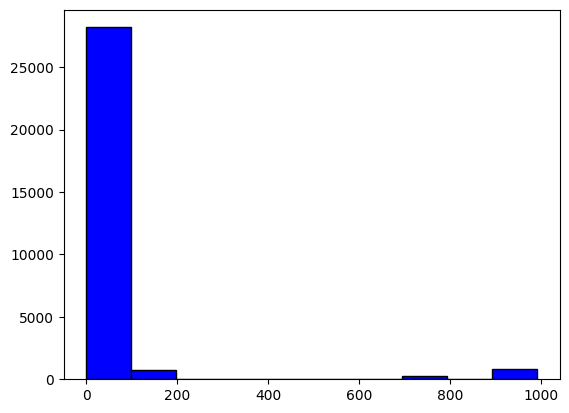

In [37]:
plt.hist(Speed[-1][:,0]**2 + Speed[-1][:,1]**2, bins=10, color='blue', edgecolor='black')

# Distribución de Boltzman < velocidades $f(v)$ >  :






In [10]:
#Fitting function
from scipy.optimize import curve_fit

def func(v, A):
  p = A*v*np.exp(-(A*v**2)/(2))
  return p

Ao = 14.




[32.2, 1.8, 17.8]
[1, 1, 1]
(0, 12.278809755338653)
[ 1.8        11.93333333 22.06666667 32.2       ]


ValueError: x and y must have same first dimension, but have shapes (3,) and (4,)

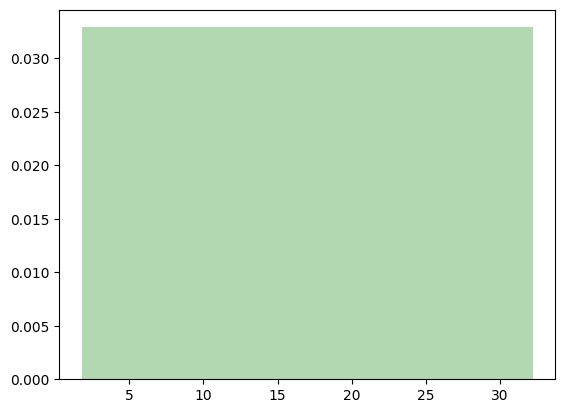

In [11]:
V = []

for j in range(0,N):
  pj = Ensemble_Particles[j]
  v = pj.velocity[-1]
  vm = np.sqrt(v[0]**2 + v[1]**2)
  V.append(vm)

V = np.round(V, 1)
Vl = V.tolist()
Vs = set(Vl)
VL = list(Vs)

Vv = []
for i in range(0,len(VL)):
  n = np.where(V == VL[i])
  Vv.append(len(n[0]))
print(VL)
print(Vv)

params = stats.maxwell.fit(V, floc=0)
print(params)

A = plt.hist(V,len(V), facecolor='g', alpha=0.3, density=True)
print(A[1])

x = np.linspace(0, 60, 100)
plt.plot(A[0],A[1])
#plt.plot(x, stats.maxwell.pdf(x, *params), lw=3)

plt.grid()
plt.xlabel('speed')
plt.ylabel('N particles')
plt.show()



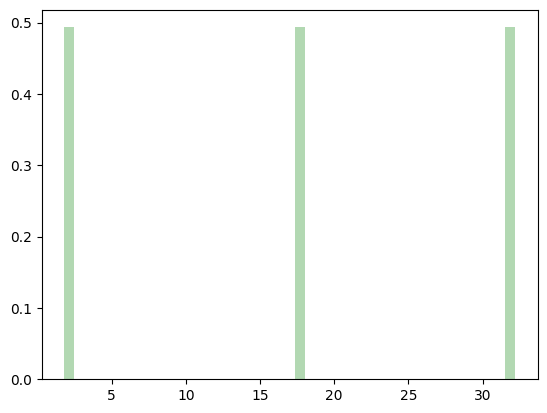

In [12]:
fig = plt.figure()
ax = fig.gca()

def actualizar(i):
  i = i*FPS
  ax.clear()
  V = []
  for j in range(0,N):
    pj = Ensemble_Particles[j]
    v = pj.velocity[i]
    vm = np.sqrt(v[0]**2 + v[1]**2)
    V.append(vm)
  V = np.round(V, 1)
  plt.hist(V,45, facecolor='g', alpha=0.3, density=True)

ani = animation.FuncAnimation(fig,
							func = actualizar,
							frames = int(len(time)/FPS),
						  blit=False,
							repeat=True)

ani.save('Histogram_speed.gif', writer = "pillow", fps=10)

# Animación:

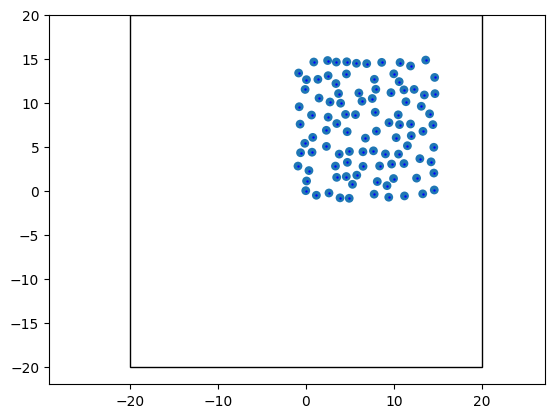

In [39]:
fig = plt.figure()
ax = fig.gca()

def actualizar(i):
  i = i*FPS
  ax.clear()
  ax.set_aspect("equal", adjustable="datalim")
  ax.set_xlim(inferior_box -2, superior_box)
  ax.set_ylim(inferior_box -2 , superior_box)
  ax.add_patch(
      patches.Rectangle((inferior_box, inferior_box),
                        superior_box-inferior_box, superior_box-inferior_box,
                        edgecolor='black', facecolor="none"))
  AB = []
  for j in range(0,N):
    pj = Ensemble_Particles[j]
    aj = pj.position[i,0]
    bj = pj.position[i,1]
    ax.add_patch(plt.Circle((aj,bj), pj.radius))
    plt.scatter(pj.position[i,0],pj.position[i,1],s=(pj.radius),c='b')
    AB.append((aj,bj))

ani = animation.FuncAnimation(fig,
							func = actualizar,
							frames = int(len(time)/FPS),
						  blit=False,
							repeat=True)

ani.save('Ideal_gas.gif', writer = "pillow", fps=10)

In [38]:
# chat gpt

fig = plt.figure()
ax = fig.gca()
ax.set_aspect("equal", adjustable="datalim")
ax.set_xlim(inferior_box - 2, superior_box)
ax.set_ylim(inferior_box - 2, superior_box)
ax.add_patch(
    patches.Rectangle((inferior_box, inferior_box),
                      superior_box - inferior_box, superior_box - inferior_box,
                      edgecolor='black', facecolor="none"))
scat = ax.scatter([], [], s=[], c='b')

def actualizar(i):
    idx = i * FPS
    AB = np.zeros((N, 2))
    for j in range(N):
        pj = Ensemble_Particles[j]
        AB[j] = pj.position[idx]
    scat.set_offsets(AB)
    scat.set_sizes(Ensemble_Particles[0].radius * 100)  # Ajusta el tamaño de las partículas
    return scat,

ani = animation.FuncAnimation(fig,
                              func=actualizar,
                              frames=int(len(time) / FPS),
                              blit=True,  # Indica que solo los objetos que cambian necesitan ser actualizados
                              repeat=True)

ani.save('Ideal_gas.gif', writer="pillow", fps=10)


TypeError: len() of unsized object

Error in callback <function _draw_all_if_interactive at 0x7f4fd3a35000> (for post_execute):


TypeError: len() of unsized object

TypeError: len() of unsized object

<Figure size 640x480 with 1 Axes>